ORDINAL REGRESSION → ENRICHMENT ANALYSIS PIPELINE

[1/4] Selecting top 10 features using ANOVA...
Selected features:
          Feature  F_statistic
2   Hexyl_acetate    34.717358
1   Butyl_acetate    23.445217
0   Ethyl_acetate    22.760049
14       Random_5     2.064297
9      Malic_acid     1.805880

[2/4] Preparing enrichment analysis...
Selected: 10 features
Background: 15 features

[3/4] Running enrichment analysis...

[4/4] Enrichment Results Summary:

Chemical Classes (significant at p<0.05):
  No significantly enriched classes

Pathways (significant at p<0.05):
  No significantly enriched pathways


/var/folders/_4/f_rgwft14s14_j1xnpz_zn7c0000gn/T/ipykernel_66754/508608566.py:285: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  class_df['-log10(p)'] = -np.log10(class_df['P_adjusted'])
/var/folders/_4/f_rgwft14s14_j1xnpz_zn7c0000gn/T/ipykernel_66754/508608566.py:302: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pathway_df['-log10(p)'] = -np.log10(pathway_df['P_adjusted'])


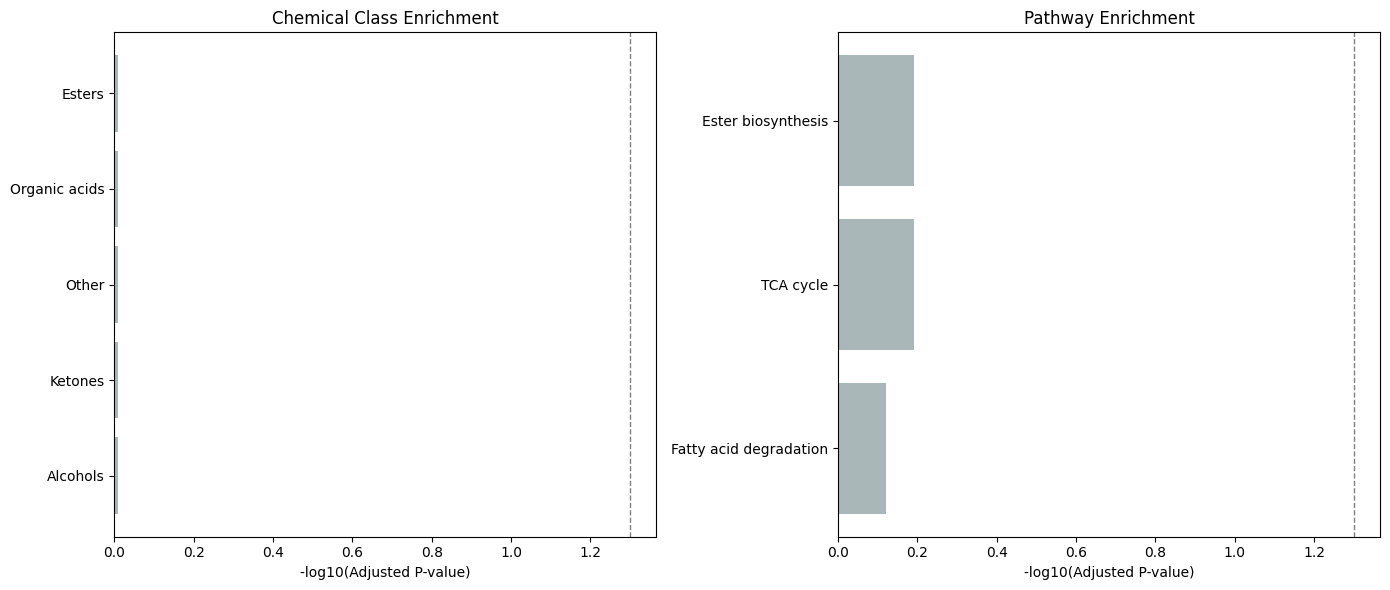


PIPELINE COMPLETE!
Files saved: class_enrichment.csv, pathway_enrichment.csv, ranked_features.csv


In [2]:
"""
Complete Workflow: Ordinal Regression/ANOVA → Feature Selection → Enrichment Analysis
======================================================================================
End-to-end pipeline for synthetic biology ML research
"""

import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================================
# STEP 1: Feature Selection from Ordinal Regression
# ============================================================================

def ordinal_anova_ranking(X, y, top_n=10):
    """
    Rank features using ANOVA F-statistic for ordinal outcomes.
    
    Parameters:
    -----------
    X : pd.DataFrame
        Feature matrix (samples × features)
    y : pd.Series or np.array
        Ordinal target (e.g., ripening stages: 0, 1, 2, 3)
    top_n : int
        Number of top features to return
        
    Returns:
    --------
    ranked_features : pd.DataFrame
        Features ranked by F-statistic with p-values
    """
    features = X.columns
    f_stats = []
    p_values = []
    
    for feature in features:
        # Group data by ordinal class
        groups = [X.loc[y == level, feature].values for level in np.unique(y)]
        
        # One-way ANOVA
        f_stat, p_val = stats.f_oneway(*groups)
        
        f_stats.append(f_stat)
        p_values.append(p_val)
    
    # Create results dataframe
    results = pd.DataFrame({
        'Feature': features,
        'F_statistic': f_stats,
        'P_value': p_values
    })
    
    # Adjust p-values for multiple testing
    results['P_adjusted'] = multipletests(results['P_value'], method='fdr_bh')[1]
    
    # Sort by F-statistic (higher = more discriminative)
    results = results.sort_values('F_statistic', ascending=False)
    
    # Select top N
    top_features = results.head(top_n)
    
    return top_features

def feature_importance_from_model(model, feature_names, top_n=10):
    """
    Extract feature importance from trained model (RandomForest, XGBoost, etc.)
    
    Parameters:
    -----------
    model : trained sklearn/xgboost model
        Must have feature_importances_ attribute
    feature_names : list
        Names of features
    top_n : int
        Number of top features to return
        
    Returns:
    --------
    pd.DataFrame with ranked features
    """
    importances = model.feature_importances_
    
    results = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    results = results.sort_values('Importance', ascending=False)
    return results.head(top_n)


# ============================================================================
# STEP 2: Enrichment Analysis (from previous artifact)
# ============================================================================

from scipy.stats import hypergeom

class EnrichmentAnalyzer:
    """Simplified version - see full implementation in previous artifact"""
    
    def __init__(self, compound_database):
        self.database = compound_database
        self._build_annotations()
    
    def _build_annotations(self):
        self.feature_to_class = {}
        self.feature_to_pathway = {}
        
        for feature, info in self.database.items():
            self.feature_to_class[feature] = info.get('class', 'Unknown')
            self.feature_to_pathway[feature] = info.get('pathway', 'Unknown')
    
    def hypergeometric_enrichment(self, selected_features, all_features, 
                                   annotation_type='class', min_category_size=2):
        """Perform hypergeometric enrichment test"""
        
        if annotation_type == 'class':
            annotation_map = self.feature_to_class
        else:
            annotation_map = self.feature_to_pathway
        
        selected_annotated = [f for f in selected_features if f in annotation_map]
        all_annotated = [f for f in all_features if f in annotation_map]
        
        categories = set(annotation_map.values()) - {'Unknown'}
        results = []
        
        for category in categories:
            selected_in_cat = sum(1 for f in selected_annotated 
                                  if annotation_map.get(f) == category)
            all_in_cat = sum(1 for f in all_annotated 
                            if annotation_map.get(f) == category)
            
            if all_in_cat < min_category_size:
                continue
            
            M = len(all_annotated)
            n = all_in_cat
            N = len(selected_annotated)
            k = selected_in_cat
            
            pval = hypergeom.sf(k - 1, M, n, N)
            expected = (n / M) * N
            fold_enrichment = (k / N) / (n / M) if n > 0 else 0
            
            results.append({
                'Category': category,
                'Selected_Count': k,
                'Selected_Total': N,
                'Background_Count': n,
                'Background_Total': M,
                'Expected': expected,
                'Fold_Enrichment': fold_enrichment,
                'P_value': pval
            })
        
        df = pd.DataFrame(results)
        
        if len(df) > 0:
            df['P_adjusted'] = multipletests(df['P_value'], method='fdr_bh')[1]
            df['Significant'] = df['P_adjusted'] < 0.05
            df = df.sort_values('P_value')
        
        return df


# ============================================================================
# STEP 3: Complete Integrated Pipeline
# ============================================================================

def complete_enrichment_pipeline(X, y, compound_database, 
                                 method='anova', top_n=10,
                                 model=None):
    """
    Complete pipeline: Feature selection → Enrichment analysis
    
    Parameters:
    -----------
    X : pd.DataFrame
        Feature matrix
    y : array-like
        Ordinal target variable
    compound_database : dict
        Compound annotation database
    method : str
        'anova' or 'model' for feature selection
    top_n : int
        Number of top features to select
    model : optional
        Trained model (if method='model')
        
    Returns:
    --------
    dict with results at each step
    """
    print("="*70)
    print("ORDINAL REGRESSION → ENRICHMENT ANALYSIS PIPELINE")
    print("="*70)
    
    # Step 1: Feature Selection
    print(f"\n[1/4] Selecting top {top_n} features using {method.upper()}...")
    
    if method == 'anova':
        ranked_features = ordinal_anova_ranking(X, y, top_n=top_n)
    elif method == 'model':
        if model is None:
            raise ValueError("Must provide trained model when method='model'")
        ranked_features = feature_importance_from_model(model, X.columns, top_n=top_n)
    else:
        raise ValueError("method must be 'anova' or 'model'")
    
    print(f"Selected features:")
    print(ranked_features[['Feature', 'F_statistic' if 'F_statistic' in ranked_features else 'Importance']].head())
    
    # Step 2: Prepare for enrichment
    print(f"\n[2/4] Preparing enrichment analysis...")
    selected_features = ranked_features['Feature'].tolist()
    all_features = X.columns.tolist()
    
    print(f"Selected: {len(selected_features)} features")
    print(f"Background: {len(all_features)} features")
    
    # Step 3: Run enrichment
    print(f"\n[3/4] Running enrichment analysis...")
    analyzer = EnrichmentAnalyzer(compound_database)
    
    # Chemical class enrichment
    class_enrichment = analyzer.hypergeometric_enrichment(
        selected_features, all_features, annotation_type='class'
    )
    
    # Pathway enrichment
    pathway_enrichment = analyzer.hypergeometric_enrichment(
        selected_features, all_features, annotation_type='pathway'
    )
    
    # Step 4: Summary
    print(f"\n[4/4] Enrichment Results Summary:")
    print(f"\nChemical Classes (significant at p<0.05):")
    sig_classes = class_enrichment[class_enrichment['Significant']]
    if len(sig_classes) > 0:
        for _, row in sig_classes.iterrows():
            print(f"  - {row['Category']}: {row['Selected_Count']}/{row['Selected_Total']} "
                  f"({row['Fold_Enrichment']:.2f}x enriched, p={row['P_adjusted']:.2e})")
    else:
        print("  No significantly enriched classes")
    
    print(f"\nPathways (significant at p<0.05):")
    sig_pathways = pathway_enrichment[pathway_enrichment['Significant']]
    if len(sig_pathways) > 0:
        for _, row in sig_pathways.iterrows():
            print(f"  - {row['Category']}: {row['Selected_Count']}/{row['Selected_Total']} "
                  f"({row['Fold_Enrichment']:.2f}x enriched, p={row['P_adjusted']:.2e})")
    else:
        print("  No significantly enriched pathways")
    
    # Return all results
    return {
        'ranked_features': ranked_features,
        'selected_features': selected_features,
        'class_enrichment': class_enrichment,
        'pathway_enrichment': pathway_enrichment,
        'analyzer': analyzer
    }


# ============================================================================
# STEP 4: Visualization
# ============================================================================

def plot_enrichment_summary(results, figsize=(14, 6)):
    """
    Create comprehensive enrichment visualization
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Plot 1: Chemical class enrichment
    class_df = results['class_enrichment'].head(10)
    if len(class_df) > 0:
        class_df['-log10(p)'] = -np.log10(class_df['P_adjusted'])
        colors = ['#e74c3c' if sig else '#95a5a6' 
                  for sig in class_df['Significant']]
        
        axes[0].barh(range(len(class_df)), class_df['-log10(p)'], 
                     color=colors, alpha=0.8)
        axes[0].axvline(-np.log10(0.05), color='black', linestyle='--', 
                        linewidth=1, alpha=0.5)
        axes[0].set_yticks(range(len(class_df)))
        axes[0].set_yticklabels(class_df['Category'])
        axes[0].set_xlabel('-log10(Adjusted P-value)')
        axes[0].set_title('Chemical Class Enrichment')
        axes[0].invert_yaxis()
    
    # Plot 2: Pathway enrichment
    pathway_df = results['pathway_enrichment'].head(10)
    if len(pathway_df) > 0:
        pathway_df['-log10(p)'] = -np.log10(pathway_df['P_adjusted'])
        colors = ['#3498db' if sig else '#95a5a6' 
                  for sig in pathway_df['Significant']]
        
        axes[1].barh(range(len(pathway_df)), pathway_df['-log10(p)'], 
                     color=colors, alpha=0.8)
        axes[1].axvline(-np.log10(0.05), color='black', linestyle='--', 
                        linewidth=1, alpha=0.5)
        axes[1].set_yticks(range(len(pathway_df)))
        axes[1].set_yticklabels(pathway_df['Category'])
        axes[1].set_xlabel('-log10(Adjusted P-value)')
        axes[1].set_title('Pathway Enrichment')
        axes[1].invert_yaxis()
    
    plt.tight_layout()
    return fig


# ============================================================================
# Example Usage
# ============================================================================

if __name__ == "__main__":
    # Mock data for demonstration
    np.random.seed(42)
    
    # Simulate ripening stages (0=unripe, 1=turning, 2=ripe, 3=overripe)
    n_samples = 100
    y = np.random.choice([0, 1, 2, 3], size=n_samples, p=[0.25, 0.25, 0.3, 0.2])
    
    # Simulate features (metabolites/volatiles)
    feature_names = [
        'Ethyl_acetate', 'Butyl_acetate', 'Hexyl_acetate',  # Esters
        'Ethanol', 'Hexanol', '2-Pentanol',  # Alcohols
        'Acetone', '2-Heptanone',  # Ketones
        'Succinic_acid', 'Malic_acid',  # Organic acids
        'Random_1', 'Random_2', 'Random_3', 'Random_4', 'Random_5'  # Noise
    ]
    
    X = pd.DataFrame(
        np.random.randn(n_samples, len(feature_names)),
        columns=feature_names
    )
    
    # Add signal: esters increase with ripening
    for feature in ['Ethyl_acetate', 'Butyl_acetate', 'Hexyl_acetate']:
        X[feature] = X[feature] + y * 0.8
    
    # Mock compound database
    COMPOUND_DB = {
        'Ethyl_acetate': {'class': 'Esters', 'pathway': 'Ester biosynthesis'},
        'Butyl_acetate': {'class': 'Esters', 'pathway': 'Ester biosynthesis'},
        'Hexyl_acetate': {'class': 'Esters', 'pathway': 'Ester biosynthesis'},
        'Ethanol': {'class': 'Alcohols', 'pathway': 'Fermentation'},
        'Hexanol': {'class': 'Alcohols', 'pathway': 'Fatty acid degradation'},
        '2-Pentanol': {'class': 'Alcohols', 'pathway': 'Fatty acid degradation'},
        'Acetone': {'class': 'Ketones', 'pathway': 'Ketogenesis'},
        '2-Heptanone': {'class': 'Ketones', 'pathway': 'Fatty acid degradation'},
        'Succinic_acid': {'class': 'Organic acids', 'pathway': 'TCA cycle'},
        'Malic_acid': {'class': 'Organic acids', 'pathway': 'TCA cycle'},
        'Random_1': {'class': 'Other', 'pathway': 'Unknown'},
        'Random_2': {'class': 'Other', 'pathway': 'Unknown'},
        'Random_3': {'class': 'Other', 'pathway': 'Unknown'},
        'Random_4': {'class': 'Other', 'pathway': 'Unknown'},
        'Random_5': {'class': 'Other', 'pathway': 'Unknown'},
    }
    
    # Run complete pipeline
    results = complete_enrichment_pipeline(
        X=X,
        y=y,
        compound_database=COMPOUND_DB,
        method='anova',
        top_n=10
    )
    
    # Visualize
    fig = plot_enrichment_summary(results)
    plt.savefig('enrichment_summary.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Save results
    results['class_enrichment'].to_csv('class_enrichment.csv', index=False)
    results['pathway_enrichment'].to_csv('pathway_enrichment.csv', index=False)
    results['ranked_features'].to_csv('ranked_features.csv', index=False)
    
    print("\n" + "="*70)
    print("PIPELINE COMPLETE!")
    print("Files saved: class_enrichment.csv, pathway_enrichment.csv, ranked_features.csv")
    print("="*70)